In [1]:
from __future__ import print_function
from PIL import Image
from grpc.beta import implementations
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2
import requests
import numpy as np
# from StringIO import StringIO
from io import StringIO
from io import BytesIO

In [10]:
!pip install /pylib/package/opencv_python-4.2.0.34-cp36-cp36m-manylinux1_x86_64.whl
# !ls "/pylib"

Processing /pylib/package/opencv_python-4.2.0.34-cp36-cp36m-manylinux1_x86_64.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
!pip install opencv_python

You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
# !apt-get update
# !apt-get install -y libsm6 libxext6 libxrender-dev
# !pip install opencv-python

In [2]:
import cv2

In [103]:
image_file = "female_1409.jpg"

In [4]:
def load_test_data(image_path, size=256):
    img = cv2.imread(image_path, flags=cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, dsize=(size, size))

    img = np.expand_dims(img, axis=0)
    img = img/127.5 - 1

    return img

In [5]:
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def inverse_transform(images):
    return ((images+1.) / 2) * 255.0


def imsave(images, size, path):
    images = merge(images, size)
    images = cv2.cvtColor(images.astype('uint8'), cv2.COLOR_RGB2BGR)

    return cv2.imwrite(path, images)

In [104]:
image = np.array(Image.open(image_file))
height = image.shape[0]
width = image.shape[1]
print("Image shape:", image.shape)

Image shape: (256, 256, 3)


In [10]:
height

256

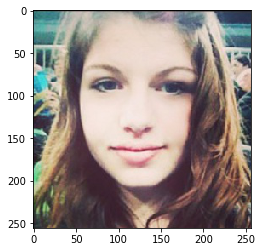

In [9]:
plt.imshow(image)
plt.show()

In [20]:
server = '192.168.62.70:9000'
host, port = server.split(':')

In [21]:
# create the RPC stub
channel = implementations.insecure_channel(host, int(port))
stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)
# create the request object and set the name and signature_name params
request = predict_pb2.PredictRequest()
request.model_spec.name = 'ugatit'
request.model_spec.signature_name = 'predict_images'

/usr/local/lib/python3.6/dist-packages/tensorflow_serving/apis/prediction_service_pb2.py:131: DeprecationWarning: beta_create_PredictionService_stub() method is deprecated. This method will be removed in near future versions of TF Serving. Please switch to GA gRPC API in prediction_service_pb2_grpc.
  'prediction_service_pb2_grpc.', DeprecationWarning)


In [22]:
request.inputs['images'].CopyFrom(tf.make_tensor_proto(image.astype(dtype=np.float32), shape=[1, height, width, 3]))

In [23]:
# sync requests
result_future = stub.Predict(request, 30.)

# For async requests
# result_future = stub.Predict.future(request, 10.)
# result_future = result_future.result()

In [63]:
# print(repr(result_future))
# result_future
# print(result_future["conv_images"].dtype)
print(result_future["conv_images"].tensor_shape.dim[1].size)
print(result_future["conv_images"].tensor_shape.dim[2].size)
print(result_future["conv_images"].tensor_shape.dim[3].size)

TypeError: 'PredictResponse' object is not subscriptable

In [52]:
float_output = np.array(result_future.outputs['conv_images'].float_val)
height = result_future.outputs['conv_images'].tensor_shape.dim[1].size
width = result_future.outputs['conv_images'].tensor_shape.dim[2].size
float_output = np.reshape(float_output, (height, width,3))
float_output

array([[[-0.87559253,  0.15217564,  0.39405042],
        [-0.87452489,  0.15854266,  0.40020347],
        [-0.87194252,  0.1506674 ,  0.41269231],
        ...,
        [-0.92570406, -0.89226323, -0.72252947],
        [-0.91946882, -0.88450497, -0.7003814 ],
        [-0.91947794, -0.8785665 , -0.69049984]],

       [[-0.87478346,  0.16530859,  0.4081991 ],
        [-0.87620664,  0.17397985,  0.41647032],
        [-0.87285954,  0.16825075,  0.42390928],
        ...,
        [-0.9233799 , -0.88804084, -0.73383617],
        [-0.91795814, -0.88463807, -0.71324641],
        [-0.91862649, -0.88227797, -0.7095148 ]],

       [[-0.87023836,  0.20535119,  0.4244805 ],
        [-0.87018096,  0.21322532,  0.42832434],
        [-0.86486775,  0.20419483,  0.43247256],
        ...,
        [-0.92156959, -0.88684189, -0.73200321],
        [-0.91706294, -0.88286757, -0.71662867],
        [-0.91832036, -0.87706304, -0.71016335]],

       ...,

       [[-0.88493323, -0.73453373, -0.75578815],
        [-0

In [53]:
float_output.shape

(256, 256, 3)

In [54]:
output_inverse = inverse_transform(float_output)
output_inverse

array([[[ 15.86195245, 146.90239348, 177.74142846],
        [ 15.99807635, 147.71418951, 178.52594197],
        [ 16.32732868, 146.71009339, 180.11826932],
        ...,
        [  9.4727321 ,  13.73643771,  35.37749246],
        [ 10.26772544,  14.72561583,  38.20137173],
        [ 10.2665627 ,  15.4827708 ,  39.46127012]],

       [[ 15.96510932, 148.57684582, 179.54538547],
        [ 15.78365386, 149.6824307 , 180.59996568],
        [ 16.21040896, 148.9519712 , 181.54843278],
        ...,
        [  9.769063  ,  14.27479282,  33.93588781],
        [ 10.4603371 ,  14.70864594,  36.56108335],
        [ 10.37512287,  15.00955939,  37.03686342]],

       [[ 16.54460862, 153.68227657, 181.62126347],
        [ 16.55192703, 154.6862283 , 182.11135358],
        [ 17.22936228, 153.53484068, 182.640251  ],
        ...,
        [  9.99987781,  14.42765862,  34.16959047],
        [ 10.57447538,  14.93438423,  36.12984449],
        [ 10.41415438,  15.67446291,  36.95417225]],

       ...,

      

In [55]:
output_inverse.shape

(256, 256, 3)

In [56]:
output_cvt = cv2.cvtColor(output_inverse.astype('uint8'), cv2.COLOR_RGB2BGR)
output_cvt

array([[[177, 146,  15],
        [178, 147,  15],
        [180, 146,  16],
        ...,
        [ 35,  13,   9],
        [ 38,  14,  10],
        [ 39,  15,  10]],

       [[179, 148,  15],
        [180, 149,  15],
        [181, 148,  16],
        ...,
        [ 33,  14,   9],
        [ 36,  14,  10],
        [ 37,  15,  10]],

       [[181, 153,  16],
        [182, 154,  16],
        [182, 153,  17],
        ...,
        [ 34,  14,   9],
        [ 36,  14,  10],
        [ 36,  15,  10]],

       ...,

       [[ 31,  33,  14],
        [ 31,  34,  15],
        [ 32,  35,  15],
        ...,
        [ 24,  53,  54],
        [ 17,  39,  42],
        [ 27,  57,  59]],

       [[ 32,  35,  14],
        [ 32,  35,  15],
        [ 33,  36,  15],
        ...,
        [ 15,  32,  33],
        [ 10,  22,  23],
        [ 21,  43,  45]],

       [[ 32,  34,  14],
        [ 33,  35,  15],
        [ 34,  36,  15],
        ...,
        [  9,  21,  21],
        [  7,  16,  17],
        [ 16,  34,  35]]

In [57]:
output_cvt.shape

(256, 256, 3)

In [59]:
cv2.imwrite('output.jpg', output_cvt)

True

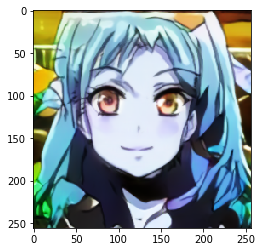

In [60]:
plt.imshow(output_cvt)
plt.show()

In [24]:
# get the results
output = np.array(result_future.outputs['conv_images'].int64_val)
height = result_future.outputs['conv_images'].tensor_shape.dim[1].size
width = result_future.outputs['conv_images'].tensor_shape.dim[2].size

# image_mask = np.reshape(output, (height, width))
# plt.imshow(image_mask)
# plt.show()

ValueError: cannot reshape array of size 0 into shape (256,256)

# function

In [70]:
# server = '192.168.62.70:9000'
# image (256,256,3)
def ugatit_grpc(server,image):
    height = image.shape[0]
    width = image.shape[1]
    print("Image shape:", image.shape)
      
    host, port = server.split(':')
    channel = implementations.insecure_channel(host, int(port))
    stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)
    # create the request object and set the name and signature_name params
    request = predict_pb2.PredictRequest()
    request.model_spec.name = 'ugatit'
    request.model_spec.signature_name = 'predict_images'
    request.inputs['images'].CopyFrom(tf.make_tensor_proto(image.astype(dtype=np.float32), shape=[1, 256, 256, 3]))

    # sync requests
    result_future = stub.Predict(request, 30.)

    float_output = np.array(result_future.outputs['conv_images'].float_val)
    height = result_future.outputs['conv_images'].tensor_shape.dim[1].size
    width = result_future.outputs['conv_images'].tensor_shape.dim[2].size
    float_output = np.reshape(float_output, (height, width,3))

#     output_inverse = inverse_transform(float_output)
    output_inverse = ((float_output+1.) / 2) * 255.0
    
    return output_inverse.astype('uint8')

Image shape: (256, 256, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow_serving/apis/prediction_service_pb2.py:131: DeprecationWarning: beta_create_PredictionService_stub() method is deprecated. This method will be removed in near future versions of TF Serving. Please switch to GA gRPC API in prediction_service_pb2_grpc.
  'prediction_service_pb2_grpc.', DeprecationWarning)


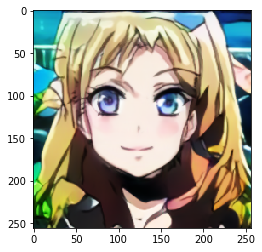

In [71]:
server = '192.168.62.70:9000'

image_file = "female_1409.jpg"
image = np.array(Image.open(image_file))
 
conv_image = ugatit_grpc(server, image)
 
# save to file
output_bgr = cv2.cvtColor(conv_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_bgr.jpg', output_cvt)

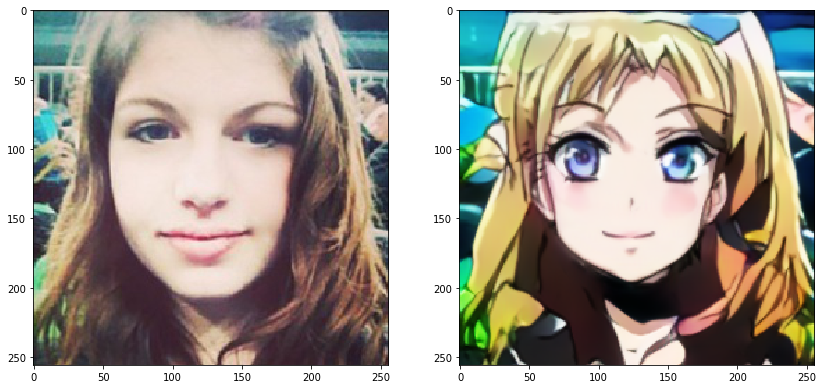

In [72]:
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
plt.imshow(image, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(conv_image, 'gray', interpolation='none')
# plt.imshow(image_mask, 'jet', interpolation='none', alpha=0.7)
plt.show()

In [87]:
image_path = 'me.png'

img = cv2.imread(image_path, flags=cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# sample_image = np.asarray(img)

In [88]:
# height, width, channels = img.shape
img.shape

(534, 409, 3)

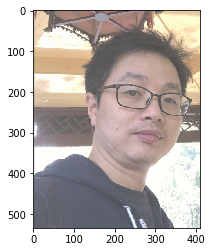

In [89]:
plt.imshow(img, 'gray', interpolation='none', alpha=0.7)


In [90]:
height, width, channels = img.shape # (534, 409, 3)
scale_height = height / 256.0
scale_width  = width / 256.0

img_resize = cv2.resize(img, dsize=(256, 256))
img_resize = img_resize/127.5 - 1

In [91]:
server = '192.168.62.70:9000'
conv_image = ugatit_grpc(server, img_resize)

Image shape: (256, 256, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow_serving/apis/prediction_service_pb2.py:131: DeprecationWarning: beta_create_PredictionService_stub() method is deprecated. This method will be removed in near future versions of TF Serving. Please switch to GA gRPC API in prediction_service_pb2_grpc.
  'prediction_service_pb2_grpc.', DeprecationWarning)


In [97]:
def scale_img(img, size):
    width = int(img.shape[1] * size[1])
    height = int(img.shape[0] * size[0])
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    print('Resized Dimensions : ',resized.shape)
    return resized


In [98]:
conv_image_scale = scale_img(conv_image,[scale_height,scale_width])

Resized Dimensions :  (534, 409, 3)


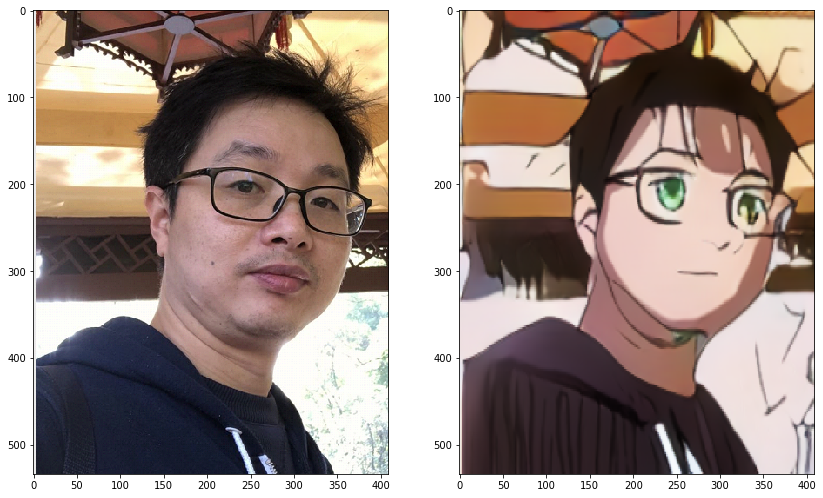

In [99]:
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
plt.imshow(img, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(conv_image_scale, 'gray', interpolation='none')
# plt.imshow(image_mask, 'jet', interpolation='none', alpha=0.7)
plt.show()

# restful api

## image-in (256x256) and run grpc

In [105]:
# load imge
# image_path = 'me.png'
def load_image(image_path):
    image = np.array(Image.open(image_path))
    height = image.shape[0]
    width = image.shape[1]
    print("Image shape:", image.shape)
    return image

In [106]:
server = '192.168.62.70:9000'
image_file = "female_1409.jpg"
image = load_image(image_file)
conv_image = ugatit_grpc(server, image)
# save to file
# plt.imshow()
# plt.imshow(conv_image, 'gray', interpolation='none')


Image shape: (256, 256, 3)
Image shape: (256, 256, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow_serving/apis/prediction_service_pb2.py:131: DeprecationWarning: beta_create_PredictionService_stub() method is deprecated. This method will be removed in near future versions of TF Serving. Please switch to GA gRPC API in prediction_service_pb2_grpc.
  'prediction_service_pb2_grpc.', DeprecationWarning)


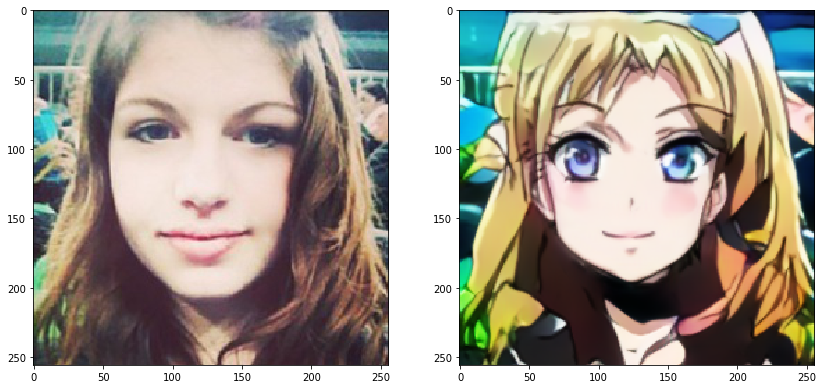

In [107]:
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
plt.imshow(image, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(conv_image, 'gray', interpolation='none')
# plt.imshow(image_mask, 'jet', interpolation='none', alpha=0.7)
plt.show()

## use RESTFul API

In [108]:
import base64
import requests
import json
import argparse

In [109]:
# Open and read image as bitstring (bytes)
input_image = open("female_1409.png", "rb").read()
print("Raw bitstring: " + str(input_image[:10]) + " ... " + str(input_image[-10:]))

Raw bitstring: b'\x89PNG\r\n\x1a\n\x00\x00' ... b'\x00\x00IEND\xaeB`\x82'


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='female_1409.png'>
  


In [117]:
import sys
print(type(input_image)) # bytes
sys.getsizeof(input_image)

<class 'bytes'>


173380

In [115]:
image = load_image("female_1409.png")
type(image)

Image shape: (256, 256, 4)


numpy.ndarray

In [118]:
# Encode image in b64
encoded_input_string = base64.b64encode(input_image)
input_string = encoded_input_string.decode("utf-8")
print("Base64 encoded string: " + input_string[:10] + " ... " + input_string[-10:])

Base64 encoded string: iVBORw0KGg ... 5ErkJggg==


In [119]:
print(type(input_string))

<class 'str'>


In [120]:
# Wrap bitstring in JSON
instance = [{"b64": input_string}]
data = json.dumps({"instances": instance})
print(data[:30] + " ... " + data[-10:])

{"instances": [{"b64": "iVBORw ... Jggg=="}]}


In [121]:
print((type(data)))

<class 'str'>


In [122]:
json_response = requests.post("http://192.168.62.70:9001/v1/models/ugatit:predict", data=data)

In [123]:
# Extract text from JSON
response = json.loads(json_response.text)

In [125]:
json_response.text

'{ "error": "Serving signature name: \\"serving_default\\" not found in signature def" }'

## 修正错误 try1

In [126]:
# Wrap bitstring in JSON
instance = [{"b64": input_string}]
data = json.dumps({"signature_name":"predict_images","instances": instance})
# print(data[:30] + " ... " + data[-10:])
json_response = requests.post("http://192.168.62.70:9001/v1/models/ugatit:predict", data=data)

In [127]:
json_response.text

'{ "error": "Failed to process element: 0 of \\\'instances\\\' list. Error: Invalid argument: JSON Value: {\\n    \\"b64\\": \\"iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAYAAABccqhmAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhepP1lmxxbmiSK6t4zZ3qgu2rXxuKq7p7uLtosZmZOJSiZQalkZmZm5khmZmbOFLM2Q0HDuT/Arr0rFFJslap6njkf7Fke7h4RHuFu9potX+6+5X/+8h/xP/7hfyn837/4Jf6/v/gZ/us//j3+2z/8Av/Xz36M//qLn+BvfvlT/I9f/gz//R9+rvBf//Hn+C9//1P8X7/8Cf5vQtb5r89e/39+/mNs+dkPseXnP8V/+Ydf4r/88u/xN3//D/hvv/wl/uYnP8Z//9GP8Novfoq/e+dthe+9/SO8/s5P8PY7P8UPf/hjvPXOm8TreOfHb+Ctt1/Dz3/2I/z0h2/hx2+/hR+++QbefOP7eOfN7+Onr7+Gn77xPfzozdfw47d+gJ+99Tp+9sYP8IsfvKbwc07//M3X8dM3f6CW/+jt73Pd7+Enb/4tfvbm3+GXb/xP/OL1/4Gfff9v8dMf/B1+8tr38A6n33rt79R3vPXWG3iDn/k6v/fNH76jINOv8/Nee/37+MEbr2m39S1u1w/fxttc/523ud1v/4DTr+EnP/wBfvgWt4/fK+3b/I4f8nNlG955/W/xo7e0ePsNtrp1OP0Ot03eq3v/O69r8SN+70/5fT9/+03+ptfxk9ffUO3P3ngdv+B3/4S/953v/x3e+cEb/K/e4W/+CX74Nv/XN/ifvv4jBZn+4TP8+A0u/8GPOK3Fj9W8H+NHb7yDn7zF//ztH/L/1v7v7/A75f94k98n7dt8

## error Type: Object is not of expected type: float"

In [128]:
# cv load img > resize > make to float
image_path = 'me.png'
img = cv2.imread(image_path, flags=cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, channels = img.shape # (534, 409, 3)
scale_height = height / 256.0
scale_width  = width / 256.0

img_resize = cv2.resize(img, dsize=(256, 256))
img_resize = img_resize/127.5 - 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


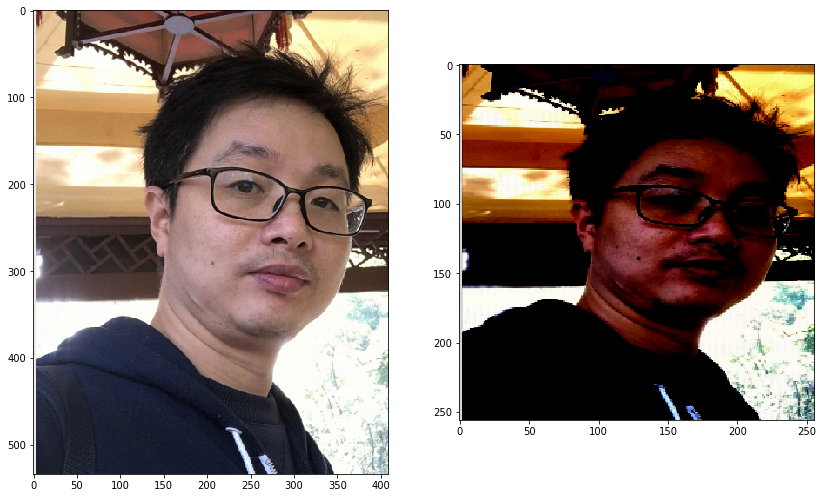

In [129]:
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
plt.imshow(img, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(img_resize, 'gray', interpolation='none')
# plt.imshow(image_mask, 'jet', interpolation='none', alpha=0.7)
plt.show()

In [133]:
# img_resize # (256, 256, 3)

# Encode image in b64
encoded_input_string = base64.b64encode(img_resize)
input_string = encoded_input_string.decode("utf-8")
print("Base64 encoded string: " + input_string[:10] + " ... " + input_string[-10:])

Base64 encoded string: fHt7e3t76z ... i4uLi4uOg/


In [134]:
# Wrap bitstring in JSON
instance = [{"b64": input_string}]
data = json.dumps({"signature_name":"predict_images","instances": instance})
# print(data[:30] + " ... " + data[-10:])
json_response = requests.post("http://192.168.62.70:9001/v1/models/ugatit:predict", data=data)

In [135]:
json_response.text

'{ "error": "Failed to process element: 0 of \\\'instances\\\' list. Error: Invalid argument: JSON Value: {\\n    \\"b64\\": \\"fHt7e3t76z98e3t7e3vrP7q6urq6uuo/enp6enp66j+6urq6urrqPzo6Ojo6Ouo/kJKSkpKSwj9QUFBQUFDQv9ra2tra2tq/lJSUlJSUxL/19PT09PTkv7i3t7e3t+e/mJaWlpaWxr92dnZ2dnbmv3h3d3d3d+e/GBUVFRUVtb/x8PDw8PDgv7Szs7Ozs+O/3N3d3d3d3T8gFhYWFhamPyAdHR0dHb2/fn19fX197T/08/Pz8/PjP9TS0tLS0tI//Pv7+/v76z80MzMzMzPjP5iampqamso/fHt7e3t76z8yMTExMTHhP5CTk5OTk8M/urm5ubm56T/c3Nzc3NzcPxATExMTE7M/eHh4eHh46D9cW1tbW1vbPwAUFBQUFJQ/+Pj4+Pj46D9cXFxcXFzcPwAQEBAQEHA/+Pf39/f35z9cWlpaWlraPyAcHBwcHJy/ODg4ODg46D/c29vb29vbPwAYGBgYGIg/Ojk5OTk56T9gXl5eXl7ePyAbGxsbG7s/eHd3d3d35z/c3d3d3d3dPyAdHR0dHb0/IB4eHh4erj+YlpaWlpbGv9rZ2dnZ2dm/2tnZ2dnZ2b8zMzMzMzPjvzg4ODg4OOi/Xl1dXV1d3b80NDQ0NDTkv7i3t7e3t+e/YF9fX19f37+0tLS0tLTkv7i3t7e3t+e/MjIyMjIy4r+2tra2trbmv3x7e3t7e+u/ABQUFBQUlD+Yl5eXl5fHv9bW1tbW1ta/fHt7e3t76z/09PT09PTkP9jW1tbW1tY/lJOTk5OTw79WVVVVVVXVvzIyMjIyMuK/cHBwcHBw4L81NTU1NTXlv3h4eHh4eOi/srGxsbGx4b81NTU1NTXlv/f29vb29ua/MzMzMzMz

## test 3  opencv -> restful request

In [138]:
image = "female_1409.png"
URL = "http://192.168.62.70:9001/v1/models/ugatit:predict" 
headers = {"content-type": "application/json"}
image_content = cv2.imread(image,1).astype('uint8').tolist()
body = {"signature_name":"predict_images","instances": [{"images": image_content}]}
r = requests.post(URL, data=json.dumps(body), headers = headers) 
print(r.text)

{
    "predictions": [[[[0.252553731, -0.106515378, -0.757167578], [0.249953404, -0.114455201, -0.759313703], [0.258090019, -0.105705462, -0.754598916], [0.273845792, -0.0871157274, -0.746952474], [0.289587706, -0.0666862428, -0.738870502], [0.309488326, -0.04613268, -0.730659366], [0.320162982, -0.0340103619, -0.724107], [0.324787468, -0.0234145019, -0.719490826], [0.328776181, -0.0143281389, -0.718383193], [0.329299629, -0.00835244916, -0.715399504], [0.33279708, 0.000191211686, -0.710047245], [0.337988526, 0.0105010122, -0.702024], [0.341089606, 0.0101182424, -0.69520849], [0.33899045, 0.00706610177, -0.693404198], [0.327696443, -0.00984322466, -0.692298949], [0.312587172, -0.0232037641, -0.694071591], [0.310169935, -0.0239702426, -0.69114995], [0.313820332, -0.0203710459, -0.678729653], [0.318847716, -0.012294149, -0.668081224], [0.322197586, -0.00560352253, -0.659291], [0.31464538, -0.0135570792, -0.656470954], [0.300866693, -0.0238206461, -0.660720408], [0.292707354, -0.042837820

# 解析返回包

In [140]:
# response_image = r.text['predictions']
data = json.loads(r.text)

# img = np.asarray(data['predictions']
# type(data['predictions'])  # list
conv_img_np = np.asarray(data['predictions'])
# conv_img_np.shape

conv_img_np.shape  #(1,256,256,256)

conv_img_np.reshape(256,256,3)

img_inverse = ((conv_img_np+1.) / 2) * 255.0
img_inverse = img_inverse.reshape(256,256,3)
img_inverse_int = img_inverse.astype('uint8')
# cv2.cvtColor(, cv2.COLOR_RGB2BGR)
# cv2.imwrite("image3.jpg", img_inverse_int)

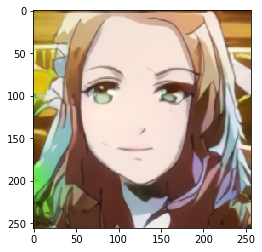

In [164]:
# img_inverse_int
plt.imshow(img_inverse_int, 'gray', interpolation='none')


## 综合

imread函数有两个参数，第一个参数是图片路径，第二个参数表示读取图片的形式，有三种：  

cv2.IMREAD_COLOR：加载彩色图片，这个是默认参数，可以直接写1。  
cv2.IMREAD_GRAYSCALE：以灰度模式加载图片，可以直接写0。  
cv2.IMREAD_UNCHANGED：包括alpha，可以直接写-1  

In [167]:
# out put (256,256,3) , and scale
def get_img_content(image):
#     image = "female_1409.png"
    image_content = cv2.imread(image,1).astype('uint8').tolist()
    
    return image_content


In [168]:
def make_rest_request(image_content,URL):
# URL = "http://192.168.62.70:9001/v1/models/ugatit:predict" 
    headers = {"content-type": "application/json"}
    body = {"signature_name":"predict_images","instances": [{"images": image_content}]}
    r = requests.post(URL, data=json.dumps(body), headers = headers) 
#     print(r.text)
    # response_image = r.text['predictions']
    data = json.loads(r.text)
    # type(data['predictions'])  # list
    conv_img_np = np.asarray(data['predictions'])
#     conv_img_np.shape  #(1,256,256,256)
    conv_img_np = conv_img_np.reshape(256,256,3)
    img_inverse = ((conv_img_np+1.) / 2) * 255.0
    img_inverse_int = img_inverse.astype('uint8')
    return img_inverse_int

In [169]:
URL = "http://192.168.62.70:9001/v1/models/ugatit:predict" 
image_content = get_img_content("female_1409.png")
result_img =  make_rest_request(image_content,URL)

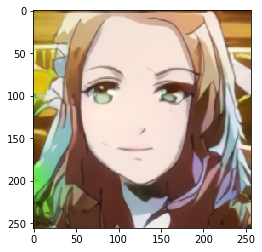

In [170]:
plt.imshow(result_img, 'gray', interpolation='none')


## 优化

In [172]:
# image_content  : list of uint8


In [176]:
image_file = "me.png"
image = cv2.imread(image_file,1).astype('uint8')  # np arrary

In [177]:
height, weigh,_ = image.shape

In [178]:
image.shape

(534, 409, 3)

In [208]:
def get_img_content_info(image_file):
    image = cv2.imread(image_file,1).astype('uint8')  # np arrary
    height, weigh,_ = image.shape
    scale_height = height / 256.0
    scale_width  = width / 256.0
    img_resize = cv2.resize(image, dsize=(256, 256))
#     img_resize = img_resize/127.5 - 1
    image_content = img_resize.astype('uint8').tolist()
    return image_content, scale_height, scale_width

In [209]:
def make_rest_request_scaled_size(image_content,URL):
# URL = "http://192.168.62.70:9001/v1/models/ugatit:predict" 
    headers = {"content-type": "application/json"}
    body = {"signature_name":"predict_images","instances": [{"images": image_content}]}
    r = requests.post(URL, data=json.dumps(body), headers = headers) 
    data = json.loads(r.text)
    conv_img_np = np.asarray(data['predictions'])
    conv_img_np = conv_img_np.reshape(256,256,3)
    img_inverse = ((conv_img_np+1.) / 2) * 255.0
    img_inverse_int = img_inverse.astype('uint8')
    

    return img_inverse_int

In [210]:
def ger_rest_request_from_file(file_name):
    URL = "http://192.168.62.70:9001/v1/models/ugatit:predict" 
    image_content, scale_height, scale_width = get_img_content_info(file_name)
    
    result_img =  make_rest_request_scaled_size(image_content,URL)
    
    width = int(256 * scale_width)
    height = int(256 * scale_height)
    dim = (width, height)
    resized = cv2.resize(result_img, dim, interpolation = cv2.INTER_AREA)
    
    return resized
    

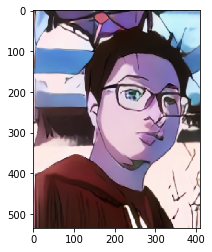

In [211]:
result_img = ger_rest_request_from_file("me.png")
plt.imshow(result_img, 'gray', interpolation='none')

In [212]:
result_img.shape

(534, 409, 3)

In [207]:
# plt.imshow(result_img, 'gray', interpolation='none')
